# Validate CNN CHM with airborne lidar grids (LVIS): 
### read in & concat large data frame and plot
Paul Montesano  
Oct 2023

In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

import sklearn.metrics as metrics
from scipy import stats


/tmp/ipykernel_2446074/615917861.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Paths from Sept 2023 work

In [4]:
# NOTE - we should organize our various main dirs so that the structures are the same - this makes the code easier to run
OUT_CHM_SUBSET = 'dm_10m'
OUT_CHM = '20231014_chm'
dir_main = f'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/{OUT_CHM}'

## Setup Paths

In [5]:
dir_chm = f'{dir_main}/{OUT_CHM_SUBSET}'

dir_validate_main =   f'{dir_chm}/validate' # validation subdirs will sit here
!mkdir -p $dir_validate_main
dir_footprints = f'{dir_chm}/footprints'
!mkdir -p $dir_footprints

nowtime = pd.Timestamp.now().strftime('%Y%m%d')
nowtime

dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate'

In [6]:
LIST_REF_METRICS = ['ht_m_ref_RH080','ht_m_ref_RH085','ht_m_ref_RH090']

In [7]:
VAL_SUBDIR = 'LVISRH080_RH085_RH090'
dir_val_csv = os.path.join(dir_validate_main, VAL_SUBDIR)
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/LVISRH080_RH085_RH090'

In [8]:
dir_val_smry = os.path.join(os.path.dirname(dir_val_csv), 'summaries')
!mkdir -p $dir_val_smry
dir_val_smry

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/summaries'

In [9]:
dir_val_plots = os.path.join(os.path.dirname(dir_val_csv), 'plots')
!mkdir -p $dir_val_plots
dir_val_plots

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots'

#### vhr metadata

In [10]:
# OUTDIR_SRLITE = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1'
# TARGET = 'alaska*'
# TARGET_DIR_TOA = f'{OUTDIR_SRLITE}/toa/{TARGET}'
# SEARCH_STRING = '/**/*.xml'

TARGET_DIR_TOA = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m'
SEARCH_STRING = '/*.xml'
f_list_toa_xml = glob.glob(f"{TARGET_DIR_TOA}{SEARCH_STRING}", recursive=True)
len(f_list_toa_xml)

3323

In [11]:
%%time

import importlib
importlib.reload(vhrlib)

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)
vhr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3323 entries, 0 to 0
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   satid       3323 non-null   object             
 1   catid       3323 non-null   object             
 2   tlctime     3323 non-null   datetime64[ns, UTC]
 3   gsd         3323 non-null   float64            
 4   sunaz       3323 non-null   float64            
 5   sunel       3323 non-null   float64            
 6   az          3323 non-null   float64            
 7   el          3323 non-null   float64            
 8   intrack     3323 non-null   float64            
 9   crosstrack  3323 non-null   float64            
 10  offnadir    3323 non-null   float64            
 11  cloudcover  3323 non-null   float64            
 12  scandir     3323 non-null   object             
 13  ULLON       3323 non-null   float64            
 14  ULLAT       3323 non-null   float64        

### Put VHR metadata onto footprints gpkg

In [12]:
footprints_fn = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/footprints/footprints_chm_20231023.gpkg'
footprint_gdf_chm = gpd.read_file(footprints_fn)

In [13]:
footprint_gdf_chm_updated = pd.merge(footprint_gdf_chm, vhr_df.drop(columns=['URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE','ULLON','ULLAT','ULHAE']), how='left', on=['catid'])
footprint_gdf_chm_updated.to_file(footprints_fn.split('.gpkg')[0] + '_vhrmeta.gpkg', driver='GPKG')

### Training and non-training sets (SRlite metrics & July/Aug)

In [14]:
list_strips_CHMfootprints = footprint_gdf_chm_updated.catid.to_list()
len(list_strips_CHMfootprints)

946

In [15]:
# get the strips for which there is a validation CSV 
list_val_csv = glob.glob(dir_val_csv + '/*.csv')
list_val_catid_from_CSV = list(set([os.path.basename(fn).split('_')[3].split('-chm')[0] for fn in list_val_csv]))

In [16]:
strips_train_df = pd.read_csv(os.path.join(dir_main , 'train_strips_0708_arcBorC_v20231017.csv'))
strips_nontrain_df = pd.read_csv(os.path.join(dir_main , 'nontrain_strips_0708_arcBorC_v20231017.csv'))

strips_train_df['footprint_name'] = strips_train_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_train_df['catid'] = strips_train_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_train = strips_train_df.catid.to_list()

strips_nontrain_df['footprint_name'] = strips_nontrain_df['srlitePath'].apply(os.path.basename).str.split('-sr', expand=True)[0]
strips_nontrain_df['catid'] = strips_nontrain_df['footprint_name'].str.split('_', expand=True)[3]
list_strips_nontrain = strips_nontrain_df.catid.to_list()

list_strips_val_train = [x for x in list_strips_train if x in list_val_catid_from_CSV]          # need list_val_catid_from_df
list_strips_val_nontrain = [x for x in list_strips_nontrain if x in list_val_catid_from_CSV]    # need list_val_catid_from_df

print(f"Strips used:")
print(f"\tfrom model training set:\t{len(list_strips_train)}")
print(f"\tfrom non-training set:\t\t{len(list_strips_nontrain)}")
print(f"Total strips anticipated:\t\t{len(list_strips_train) + len(list_strips_nontrain)}\n")

print(f"Total strips modeled to CHM:\t\t{len(list_strips_CHMfootprints)}\n")

print(f"Total strips (from CSVs) used for this validation:\t{len(list_val_catid_from_CSV)}")
print(f"\tfrom the model-training set:\t{len(list_strips_val_train)}")
print(f"\tfrom the non-training set:\t{len(list_strips_val_nontrain)}")

Strips used:
	from model training set:	526
	from non-training set:		424
Total strips anticipated:		950

Total strips modeled to CHM:		946

Total strips (from CSVs) used for this validation:	438
	from the model-training set:	202
	from the non-training set:	236


#### TODO - Examine SRlite metadata for filtering
`srlite_metrics.ipynb`  
custom r2_score thresholding

In [17]:
THRESH_R2SCORE = 0.5

In [18]:
if True:
    # Flexible threshold: a table of the NIR r2score for each VHR strip
    srlite_metrics_NIR_r2score_df = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_metrics_NIR_r2score_rma_20231109.csv')
    srlite_metrics_NIR_r2score_df.head()

    list_include_catid = [catid for i, catid in enumerate(srlite_metrics_NIR_r2score_df.catid.to_list()) if srlite_metrics_NIR_r2score_df.r2_score.to_list()[i] > THRESH_R2SCORE]
    list_exclude_catid = [catid for i, catid in enumerate(srlite_metrics_NIR_r2score_df.catid.to_list()) if srlite_metrics_NIR_r2score_df.r2_score.to_list()[i] <= THRESH_R2SCORE]
else:
    # Baked in threshold: txt files with catid selected from r2_score threshold of 0.75
    list_include_catid = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_include_model_0p75.txt',sep=',', header=None)[0].tolist()
    list_exclude_catid = pd.read_csv('/home/pmontesa/ABoVE_Shrubs/srlite/csv/srlite_exclude_model_0p75.txt',sep=',', header=None)[0].tolist()

print(f"Based on r2_score threshold of {THRESH_R2SCORE} VHR strips to:")
print(f"\tinclude: {len(list_include_catid)}")
print(f"\texclude: {len(list_exclude_catid)}")

Based on r2_score threshold of 0.5 VHR strips to:
	include: 2386
	exclude: 828


#### Strips the the SRlite metrics assessment said where good
 - based on NIR r2 threshold of 0.75  
 - not yet filtered down to July/Aug

### Read in the validation CSVs

predictions made at 2m, reference LVIS is 30m, validation done at 10m --> 5 pix x 5 pix are averaged for each validation observation

In [19]:
def slope_classifier(row, THRESH=5):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.75 from srlite_metrics.ipynb
    if row["slope_ref"] < THRESH:
        return f"< {THRESH}"+u'\N{DEGREE SIGN}'
    else:
        return f">= {THRESH}"+u'\N{DEGREE SIGN}' 

def srlite_metrics_classifier(row, THRESH=THRESH_R2SCORE, LIST_CATID=list_include_catid):
    # this classification is based on whether strips meet a rigorous requirement where NIR band has r2 >= 0.75 from srlite_metrics.ipynb
    if row["catid"] in LIST_CATID:
        return f"include\nNIR r2 >= {THRESH}"
    else:
        return f"exclude\nNIR r2 < {THRESH}"  

def model_use_classifier(row, LIST_CATID=list_strips_val_train):
    if row["catid"] in LIST_CATID:
        return "train/test"
    else:
        return "test" 

In [20]:
%%time
def read_and_apply_classifiers(fn):
    df = pd.read_csv(fn)
    # Fix
    df['catid'] = df['catid'].str.split('-chm', expand=True)[0]
    
    df['slope_class'] = df.apply(slope_classifier, axis=1)
    df['srlite_class'] = df.apply(srlite_metrics_classifier, axis=1)
    df['model_use_class'] = df.apply(model_use_classifier, axis=1)

    return df
    
if True:
    with Pool(processes=35) as pool:
        DF_VAL_LIST = pool.map(partial(read_and_apply_classifiers), glob.glob(dir_val_csv + '/*.csv') )
else:
    DF_VAL_LIST = [read_and_apply_classifiers(f) for f in glob.glob(dir_val_csv + '/*.csv')]
df_val = pd.concat(DF_VAL_LIST)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260935361 entries, 0 to 12510
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ht_m_src         float64
 1   ht_m_ref_RH080   float64
 2   ht_m_ref_RH085   float64
 3   ht_m_ref_RH090   float64
 4   tcc_ref          float64
 5   slope_ref        float64
 6   cnt_ref          float64
 7   tcc_class        object 
 8   file             object 
 9   date             object 
 10  type             object 
 11  footprint_name   object 
 12  catid            object 
 13  sensor           object 
 14  year             int64  
 15  month            int64  
 16  slope_class      object 
 17  srlite_class     object 
 18  model_use_class  object 
dtypes: float64(7), int64(2), object(10)
memory usage: 38.9+ GB
CPU times: user 3min 28s, sys: 1min 43s, total: 5min 12s
Wall time: 9min 22s


In [21]:
df_val.head()

ht_m_src  ht_m_ref_RH080  ht_m_ref_RH085  ht_m_ref_RH090  tcc_ref  \
0       2.8        9.073636        9.602727       10.714545   5608.0   
1       2.4        9.073636        9.602727       10.714545   5608.0   
2       0.4       12.725294       13.531177       14.698236   6653.0   
3       0.6       12.725294       13.531177       14.698236   6653.0   
4       6.4        3.348182        3.768182        4.291818   4210.0   

   slope_ref  cnt_ref tcc_class  \
0   0.182577     11.0    41-60%   
1   0.182577     11.0    41-60%   
2   0.524835     17.0    61-80%   
3   0.524835     17.0    61-80%   
4   0.508962     11.0    41-60%   

                                                file        date      type  \
0  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
1  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
2  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
3  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
4  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   

                                      footprint_name             catid sensor  \
0  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
1  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
2  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
3  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
4  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   

   year  month slope_class            srlite_class model_use_class  
0  2019      7        < 5°  include\nNIR r2 >= 0.5      train/test  
1  2019      7        < 5°  include\nNIR r2 >= 0.5      train/test  
2  2019      7        < 5°  include\nNIR r2 >= 0.5      train/test  
3  2019      7        < 5°  include\nNIR r2 >= 0.5      train/test  
4  2019      7        < 5°  include\nNIR r2 >= 0.5      train/test

### Checking for training CSVs and CHMs...

In [22]:
# get the strips for which there is a validation CSV 
list_val_csv = glob.glob(dir_val_csv + '/*.csv')
list_val_catid_from_CSV = list(set([os.path.basename(fn).split('_')[3].split('-chm')[0] for fn in list_val_csv]))
len(list_val_catid_from_CSV)

438

In [23]:
list_val_csv[0]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/LVISRH080_RH085_RH090/WV03_20190723_M1BS_10400100506ED100-chm-dm-10m_LVIS2_ABoVE2017_0706_R1803_075300__val_2219.csv'

In [24]:
list_val_catid_from_CSV[0]

'1030010093409800'

In [25]:
list_val_catid_from_df = list(set(df_val.catid.to_list()))

In [26]:
len(list_val_catid_from_df)

438

##### These are the strips in our validation that were used for training - and are found in the names of the validation CSVs

In [27]:
list_strips_val_train_from_CSV = [x for x in list_strips_train if x in list_val_catid_from_CSV]
print(list_strips_val_train_from_CSV[0])
len(list_strips_val_train_from_CSV)

10300100342CF900


202

In [28]:
# switched around, still same length
list_strips_val_train_ = [x for x in list_val_catid_from_CSV if x in list_strips_train]
print(list_strips_val_train_[0])
len(list_strips_val_train_)

10300100965B7000


202

##### These are the strips in our validation that were used for training - and are found in the val df

In [29]:
list_strips_val_train_from_df = [x for x in list_strips_val_train if x in list_val_catid_from_df]
len(list_strips_val_train_from_df)

202

In [30]:
list_val_catid_from_df[10]

'103001009409BC00'

In [31]:
list_strips_valDF_train = [x for x in list_strips_train if x in list_val_catid_from_df]          # need list_val_catid_from_df
list_strips_valDF_nontrain = [x for x in list_strips_nontrain if x in list_val_catid_from_df]    # need list_val_catid_from_df

print(f"Total strips (from DF) used for this validation:\t{len(list_val_catid_from_df)}")
print(f"\tfrom the model-training set:\t{len(list_strips_valDF_train)}")
print(f"\tfrom the non-training set:\t{len(list_strips_valDF_nontrain)}")

Total strips (from DF) used for this validation:	438
	from the model-training set:	202
	from the non-training set:	236


In [32]:
footprint_gdf_chm['model_use_class'] = footprint_gdf_chm.apply(model_use_classifier, axis=1)
footprint_gdf_chm.drop(columns=['date']).explore(color='model_use_class', legend=True)

NameError: name 'Tru' is not defined

## Filtering

## Calc validation smry stats

In [33]:
def validation_smry_stats(g, ref_var, src_var):
    n = len(g)
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(g[ref_var], g[src_var])

    # Regression metrics
    explained_variance =  metrics.explained_variance_score(g[ref_var], g[src_var])
    mean_absolute_error = metrics.mean_absolute_error(g[ref_var], g[src_var]) 
    mse                 = metrics.mean_squared_error(g[ref_var], g[src_var]) 
    rmse                = np.sqrt(mse) 
    #mean_squared_log_error=metrics.mean_squared_log_error(g[ref_var], g[src_var])
    median_absolute_error = metrics.median_absolute_error(g[ref_var], g[src_var])
    r2score             = metrics.r2_score(g[ref_var], g[src_var])

    if False:
        print('explained_variance: ', round(explained_variance,4))    
        #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
        print('r2: ', round(r2score,4))
        print('MAE: ', round(mean_absolute_error,4))
        print('MSE: ', round(mse,4))
        print('RMSE: ', round(rmse,4))

    return pd.Series(dict(n=n, slope=slope, intercept=intercept, r_value=r_value, p_value=p_value, std_err=std_err, ref_var=ref_var, r2score = r2score, expvarscore=explained_variance, mae=mean_absolute_error, mse=mse, rmse=rmse, medae=median_absolute_error))   

## Summarize predicted vs observed
 - footprint summary  
 find which are train and non-train

 - separate VHR strips into 'training' (strips used to train the model) and 'non-training'  
 - in theory, strips used to train the model should have better results  
 - good results for strips from 'non-training' indicate a robust model  

In [34]:
%%time
df_smry_footprint_list = [df_val.groupby(['footprint_name']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in LIST_REF_METRICS ]
df_smry_footprint = pd.concat(df_smry_footprint_list, axis=0)
df_smry_footprint = footprintlib.get_attributes_from_filename(df_smry_footprint, file_col='footprint_name', image_type='CHM pred', file_split_str='-chm-dm-10m.tif', DROP_FILE_DUPLICATES=False)
df_smry_footprint

CPU times: user 4min 5s, sys: 1min 45s, total: 5min 51s
Wall time: 5min 51s


footprint_name        n     slope  intercept  \
0    WV02_20100715_M1BS_10300100064B1E00     3216  0.104370   0.086292   
1    WV02_20100804_M1BS_103001000617C000   740774  0.645976   0.678462   
2    WV02_20100824_M1BS_10300100066AFE00   444337  0.523905   0.051460   
3    WV02_20110727_M1BS_103001000D914900  1037606  0.266502  -0.029776   
4    WV02_20110804_M1BS_103001000C140300  1050685  0.408403   0.074587   
..                                   ...      ...       ...        ...   
433  WV03_20200714_M1BS_104001005E7EAE00   342790 -0.026337   0.012903   
434  WV03_20200715_M1BS_104001005EC99000   324873  0.004623  -0.000572   
435  WV03_20200729_M1BS_104001005E8CBF00   916145  0.543669  -0.090553   
436  WV03_20200802_M1BS_104001005F4BBC00    98523  0.162860  -0.063727   
437  WV03_20200803_M1BS_104001005E171900    29384  0.003799   0.016132   

      r_value        p_value   std_err         ref_var    r2score  \
0    0.457204  6.699374e-166  0.003581  ht_m_ref_RH080  -0.213941   
1    0.870735   0.000000e+00  0.000424  ht_m_ref_RH080   0.713691   
2    0.807280   0.000000e+00  0.000575  ht_m_ref_RH080   0.560801   
3    0.266591   0.000000e+00  0.000946  ht_m_ref_RH080  -2.321122   
4    0.634736   0.000000e+00  0.000485  ht_m_ref_RH080  -0.074117   
..        ...            ...       ...             ...        ...   
433 -0.023149   7.374414e-42  0.001943  ht_m_ref_RH090 -61.321977   
434  0.020150   1.549403e-30  0.000402  ht_m_ref_RH090 -25.372007   
435  0.795774   0.000000e+00  0.000432  ht_m_ref_RH090   0.471120   
436  0.535373   0.000000e+00  0.000819  ht_m_ref_RH090  -1.097194   
437  0.032750   1.962626e-08  0.000676  ht_m_ref_RH090  -1.619808   

     expvarscore       mae       mse      rmse     medae      type  \
0       0.156629  1.490202  6.921359  2.630848  0.798000  CHM pred   
1       0.741575  1.392097  4.752536  2.180031  0.722500  CHM pred   
2       0.626641  0.441213  0.591464  0.769067  0.282000  CHM pred   
3      -0.466331  0.202028  0.060389  0.245741  0.166667  CHM pred   
4       0.402815  1.958160  7.358042  2.712571  1.366316  CHM pred   
..           ...       ...       ...       ...       ...       ...   
433    -1.347053  0.300380  0.092591  0.304288  0.300000  CHM pred   
434    -0.043392  0.480466  0.240177  0.490079  0.516111  CHM pred   
435     0.620582  0.526574  0.671119  0.819218  0.360000  CHM pred   
436     0.233183  0.977383  1.499628  1.224593  0.748571  CHM pred   
437    -0.005860  1.434011  3.332354  1.825474  1.120000  CHM pred   

                catid sensor  year  month       date  
0    10300100064B1E00   WV02  2010      7 2010-07-15  
1    103001000617C000   WV02  2010      8 2010-08-04  
2    10300100066AFE00   WV02  2010      8 2010-08-24  
3    103001000D914900   WV02  2011      7 2011-07-27  
4    103001000C140300   WV02  2011      8 2011-08-04  
..                ...    ...   ...    ...        ...  
433  104001005E7EAE00   WV03  2020      7 2020-07-14  
434  104001005EC99000   WV03  2020      7 2020-07-15  
435  104001005E8CBF00   WV03  2020      7 2020-07-29  
436  104001005F4BBC00   WV03  2020      8 2020-08-02  
437  104001005E171900   WV03  2020      8 2020-08-03  

[1314 rows x 20 columns]

In [35]:
# Need to get this list earlier...need to use glob
#list_val_catid = df_smry_footprint.groupby('catid').aggregate(cnt_metrics=('catid','count')).reset_index().catid.to_list()

Now we have a table by strip that summarizes validation results with LVIS RH050, RH075, and RH098. Some of these strips are sub-optimal due to:
 - poor VHR SSG
 - cloud & cloud-shadow contamination (need to improve masking of this noise)
that will yield
 - poor SRlite and SRLite-bsed CHM estimates
 
 These data can be filtered out through metadata joins below...

In [36]:
stats_footprint_smry_fn = os.path.join(dir_validate_main, f'stats_footprint_smry_{os.path.basename(dir_val_csv)}.csv')

## Update footprint summary: VHR info and SRlite metrics

#### Examine VHR metadata for filtering

In [37]:
df_smry_footprint_updated = pd.merge(df_smry_footprint, vhr_df.drop(columns=['URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE','ULLON','ULLAT','ULHAE']), how='left', on=['catid'])

In [38]:
df_smry_footprint_updated['srlite_metrics_class'] = df_smry_footprint_updated.apply(srlite_metrics_classifier, axis=1)
df_smry_footprint_updated['model_use_class'] = df_smry_footprint_updated.apply(model_use_classifier, axis=1)

In [39]:
df_smry_footprint_updated.head()

footprint_name        n     slope  intercept  \
0  WV02_20100715_M1BS_10300100064B1E00     3216  0.104370   0.086292   
1  WV02_20100804_M1BS_103001000617C000   740774  0.645976   0.678462   
2  WV02_20100824_M1BS_10300100066AFE00   444337  0.523905   0.051460   
3  WV02_20110727_M1BS_103001000D914900  1037606  0.266502  -0.029776   
4  WV02_20110804_M1BS_103001000C140300  1050685  0.408403   0.074587   

    r_value        p_value   std_err         ref_var   r2score  expvarscore  \
0  0.457204  6.699374e-166  0.003581  ht_m_ref_RH080 -0.213941     0.156629   
1  0.870735   0.000000e+00  0.000424  ht_m_ref_RH080  0.713691     0.741575   
2  0.807280   0.000000e+00  0.000575  ht_m_ref_RH080  0.560801     0.626641   
3  0.266591   0.000000e+00  0.000946  ht_m_ref_RH080 -2.321122    -0.466331   
4  0.634736   0.000000e+00  0.000485  ht_m_ref_RH080 -0.074117     0.402815   

   ...  sunel          az         el    intrack crosstrack   offnadir  \
0  ...  46.60  100.257143  71.685714   1.714286  16.114286  16.228571   
1  ...  44.90  297.900000  69.180000   1.640000 -18.480000  18.580000   
2  ...  34.65  234.525000  69.787500 -15.300000  -9.250000  17.837500   
3  ...  44.55  196.133333  74.966667 -13.116667   0.833333  13.150000   
4  ...  43.81  205.070000  60.030000 -26.140000  -2.580000  26.290000   

  cloudcover  scandir    srlite_metrics_class model_use_class  
0      0.138  Forward   exclude\nNIR r2 < 0.5            test  
1      0.000  Forward  include\nNIR r2 >= 0.5      train/test  
2      0.005  Forward   exclude\nNIR r2 < 0.5            test  
3      0.099  Forward  include\nNIR r2 >= 0.5      train/test  
4      0.218  Forward   exclude\nNIR r2 < 0.5            test  

[5 rows x 34 columns]

In [40]:
df_smry_footprint_updated.to_csv(stats_footprint_smry_fn)
stats_footprint_smry_fn

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/stats_footprint_smry_LVISRH080_RH085_RH090.csv'

CPU times: user 8.93 ms, sys: 0 ns, total: 8.93 ms
Wall time: 8.95 ms


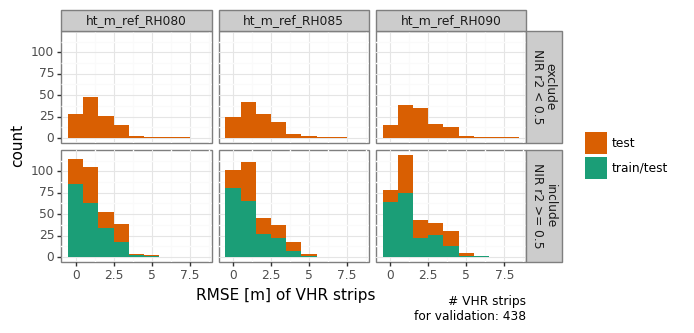

<ggplot: (1421143166973)>

In [41]:
%%time

(
    ggplot(df_smry_footprint_updated, aes('rmse', fill='model_use_class')) 
    + geom_histogram(binwidth=1)
    + labs(x = 'RMSE [m] of VHR strips', caption=f"# VHR strips\nfor validation: {int(len(df_smry_footprint_updated)/len(LIST_REF_METRICS))}")
    + theme_bw()
    + scale_fill_brewer(type='qual', palette=2, direction=-1, name=' ')
    + facet_grid('srlite_metrics_class~ref_var')
    + theme(figure_size=(6, 3))
)

#### Summarize: 
Distribution of validation observations:  
 - footprints  
 - TCC intervals

In [42]:
%%time
df_smry_footprint_tcc = df_val.groupby(['footprint_name']).aggregate({'tcc_class':'first', 'footprint_name':'count'}).rename(columns={'footprint_name':'n_obs'})#.count().add_suffix('_count')
df_smry_footprint_tcc.reset_index(inplace=True)
df_smry_footprint_tcc['catid'] = df_smry_footprint_tcc['footprint_name'].str.split('-', expand=True)[0].str.split('_', expand=True)[3]


CPU times: user 33.3 s, sys: 2.59 s, total: 35.9 s
Wall time: 35.9 s


CPU times: user 30.4 ms, sys: 3.2 ms, total: 33.6 ms
Wall time: 32.8 ms


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_fill_brewer could not recognise parameter `guides`


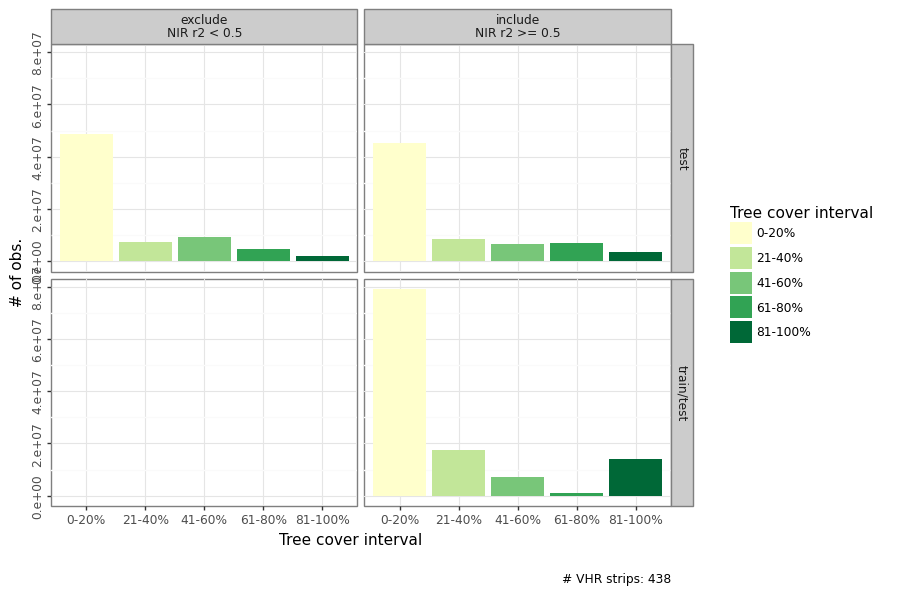

<ggplot: (1421142716130)>

In [43]:
%%time

from mizani.formatters import scientific_format


df_smry_footprint_tcc['include_class'] = df_smry_footprint_tcc.apply(srlite_metrics_classifier, axis=1)
df_smry_footprint_tcc['model_use_class'] = df_smry_footprint_tcc.apply(model_use_classifier, axis=1)

(
    ggplot(df_smry_footprint_tcc, aes(x='tcc_class', y='n_obs', fill='tcc_class') )
    + geom_bar(stat = "identity")
    + geom_label(x=4, y=3e8, label=f'n = {df_val.shape[0]:,}', fill='white')
    + theme_bw()
    + scale_fill_brewer(type='seq', palette='YlGn', guides=True, name='Tree cover interval') 
    + scale_y_continuous(labels=scientific_format(digits=1))
    + theme(figure_size=(8, 6), axis_text_y = element_text(angle=90),axis_text_x = element_text(angle=0))
    + labs(x='Tree cover interval', y='# of obs.', caption=f"# VHR strips: {int(len(df_smry_footprint)/3)}")
    + facet_grid('model_use_class~include_class')
)

In [44]:
# def plot_scatter(df_val, sample_frac, df_val_smry, ref_var, facet_var=None):
    
#     # Get # VHR strips
#     n_VHR = len(df_val.groupby(['footprint_name']).aggregate({'footprint_name':'count'}))
    
#     # Subsetting... instead of melting...
#     df_val_smry = df_val_smry[df_val_smry.ref_var == ref_var]
#     df_val_smry['rmse'] = round(df_val_smry['rmse'], 2)
    
#     #calculate best fit line
#     slope, intercept, r_value, p_value, std_err = stats.linregress(df_val[ref_var], df_val['ht_m_src'])
#     df_val['fit'] = df_val[ref_var] * slope + intercept
    
#     max_val = 30
#     p = (
#         ggplot(
#             df_val.sample(frac=sample_frac),
#             aes(x=ref_var, y='ht_m_src')
#         )
#             + labs(title='', x=f"Reference Canopy Height [m]: {ref_var.split('_')[-1]}", y='Predicted Canopy Height [m]')
#             + geom_bin2d(binwidth=0.25)
#         + geom_abline(linetype='dashed')
#         + annotate(geom='label', x=0, y=max_val, label=f"$r^2$: {round(r_value*r_value,2)}", ha='left', va='top')
#         + annotate(geom='label', x=0, y=max_val-4, label=f"rmse [m]: {df_val_smry['rmse'][0]}", ha='left', va='top')
#         + annotate(geom='label', x=0, y=max_val-8,  label=f"bias [m]: {round(intercept,2)}", ha='left', va='top')
#         + annotate(geom='label', x=20, y=max_val,   label=f"# obs: {len(df_val):,}", ha='left', va='top')
#         + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
#         + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
#         + scale_fill_cmap(cmap_name='plasma', trans='log10', name='n obs. 10 m')
        
#         #+ facet_grid(' ~ month')
#         + theme_bw()
#         + theme(figure_size=(6, 4), strip_text = element_text(size=9))
#         + labs(caption=f'{os.path.basename(dir_val_csv)}')
#     )
#     if sample_frac < 1:
#         p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') )
#     if facet_var is not None:
#         p = ( p + facet_wrap(f"~{facet_var}") )
#     print(p)

In [45]:
# def plot_scatter_melt(df_val, sample_frac, ref_var, FACET_VAR=None, LIST_ID_VARS=['year']):
    
# #     # Get count of various groups
#     df_smry_N_VHR_YEAR = df_val.groupby(['footprint_name','year']).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby(['year']).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
#     df_smry_N_VHR_YEAR['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_YEAR['n_VHR'].astype(str)
#     N_VHR   = len(df_smry_N_aVHR)
#     df_smry_N_YEARS = df_val.groupby(['year']).aggregate(n_obs_year=('year','count')).reset_index()
#     df_smry_N_YEARS['n_obs_year_str'] = f"# obs: " + df_smry_N_YEARS['n_obs_year'].astype(str)
#     N_YEARS = len(df_smry_N_YEARS)
# #     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
# #     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()
    
#     # Run the validation stats
#     df_validation_smry_stats = round(df_val.groupby(LIST_ID_VARS).apply(validation_smry_stats, ref_var, 'ht_m_src').reset_index(), 2)
#     df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
#     df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
#     df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
#     df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
#     df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    
#     df_val_m = pd.melt(df_val[LIST_ID_VARS+[ref_var]+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=[ref_var])
       
#     max_val = 30
#     p = (
#         ggplot(
#             df_val_m.sample(frac=sample_frac),
#             aes(x='value', y='ht_m_src', group=FACET_VAR)
#         )
#             + labs(title='', x=f"Reference Canopy Height [m]: {ref_var.split('_')[-1]}", y='Predicted Canopy Height [m]')
#             + geom_bin2d(binwidth=0.25)
#         + geom_abline(linetype='dashed')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
#         + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
#         + geom_label(data=df_smry_N_YEARS, mapping=aes(x=15, y=max_val, label='n_obs_year_str'), ha='left', va='top')
#         + geom_label(data=df_smry_N_VHR_YEAR, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
#         # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
#         + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
#         + scale_fill_cmap(cmap_name='plasma', trans='log10', name='n obs. 10 m')
        
#         + facet_grid(f'{FACET_VAR} ~ variable')
#         + theme_bw()
#         + theme(figure_size=(N_YEARS*4, 4), strip_text = element_text(size=9))
#         + labs(caption=f'{os.path.basename(dir_val_csv)}')
#     )
#     if sample_frac < 1:
#         p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') )
#     if FACET_VAR is not None:
#         p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
#     print(p)
    
#     return df_validation_smry_stats

In [46]:
def plot_scatter_melt_3(df_val, sample_frac, LIST_REF_VARS, FACET_VAR_LIST='year'):
    
    if FACET_VAR_LIST is None:
        LIST_ID_VARS = []
    else:
        LIST_ID_VARS = FACET_VAR_LIST
    
#     # Get count of various groups
    df_smry_N_VHR_GROUP = df_val.groupby(['footprint_name']+FACET_VAR_LIST).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby(FACET_VAR_LIST).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
    df_smry_N_VHR_GROUP['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_GROUP['n_VHR'].astype(str)
    N_VHR   = sum(df_smry_N_VHR_GROUP.n_VHR.to_list())
    
    df_smry_N_GROUPS = df_val.groupby(FACET_VAR_LIST).aggregate(n_obs_group=('type','count')).reset_index()
    df_smry_N_GROUPS['n_obs_group_str'] = "# obs: " + df_smry_N_GROUPS['n_obs_group'].astype(str)
    N_GROUPS = len(df_smry_N_GROUPS)
    
    # For fecetting nicely.
    if N_GROUPS == 3: N_GROUPS = 4
    
#     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
#     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()

    # Drop the ref vars you dont want
    LIST_REF_VARS_ALL = [x for x in df_val.columns.to_list() if "RH" in x]
    LIST_REF_VARS_RM = [var for var in LIST_REF_VARS_ALL if var not in LIST_REF_VARS]
    print(f'Cols to drop: {LIST_REF_VARS_RM}')
    df_val.drop(columns=LIST_REF_VARS_RM, inplace=True)
    
    # Change the names of the ref ht vars to make them look nicer
    LIST_REF_VARS = [x.split('_')[-1] for x in df_val.columns.to_list() if "RH" in x]
    print(LIST_REF_VARS)
    rename_dict = dict(zip([x for x in df_val.columns.to_list() if "RH" in x], LIST_REF_VARS))
    df_val.rename(rename_dict, axis=1, inplace=True)

    # Melt
    df_val_m = pd.melt(df_val[LIST_ID_VARS+LIST_REF_VARS+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=LIST_REF_VARS)
    
    # Run the validation stats
    df_validation_smry_stats = round(df_val_m.groupby(LIST_ID_VARS+['variable']).apply(validation_smry_stats, 'value', 'ht_m_src').reset_index(), 2)
    df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
    df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
    df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
    df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
    df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    df_validation_smry_stats['variable'] = df_validation_smry_stats['variable'].apply(lambda x: x.split('_')[-1])
    #print(df_val_m.head())
    max_val = 30
    fig, p = (
        ggplot(
            df_val_m.sample(frac=sample_frac),
            aes(x='value', y='ht_m_src')#, group='variable')
        )
            + labs(title='', x="Reference Canopy Height [m]", y='Predicted Canopy Height [m]')
            + geom_bin2d(binwidth=0.25)
        + geom_abline(linetype='dashed')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_GROUPS, mapping=aes(x=15, y=max_val, label='n_obs_group_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_VHR_GROUP, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
        # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
        + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
        + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')
        
        #+ facet_grid(f'. ~ {FACET_VAR}')
        + facet_grid(f'{FACET_VAR_LIST[0]} ~ {FACET_VAR_LIST[1]}')
        + theme_bw()
        + theme(figure_size=(2 + N_GROUPS*2, N_GROUPS*2), strip_text = element_text(size=9))
        + labs(caption=f'{os.path.basename(dir_val_csv)}')
    ).draw(show=True, return_ggplot=True)
    
    if sample_frac < 1:
        fig, p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') 
                 ).draw(show=False, return_ggplot=True)
    # if FACET_VAR is not None:
    #     p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
    print(p)
    METRICS_STR = '_'.join([n.split('_')[-1] for n in LIST_REF_VARS])
    out_plot_fn = os.path.join(dir_val_plots, f"plot_scatter_{'_'.join(FACET_VAR_LIST)}_nVHR{N_VHR:04}_{METRICS_STR}.png")
    fig.savefig(out_plot_fn, dpi=300)
    print(f'Saved {out_plot_fn}')
    return df_validation_smry_stats
    #return df_smry_N_VHR_GROUP

In [47]:
def plot_scatter_melt_2(df_val, sample_frac, LIST_REF_VARS, FACET_VAR='year'):
    
    if FACET_VAR is None:
        LIST_ID_VARS = []
    else:
        LIST_ID_VARS = [FACET_VAR]
    
#     # Get count of various groups
    df_smry_N_VHR_GROUP = df_val.groupby(['footprint_name',FACET_VAR]).aggregate(n_obs_footprint = ('footprint_name', 'count')).reset_index().groupby([FACET_VAR]).aggregate(n_VHR = ('footprint_name', 'count')).reset_index()
    df_smry_N_VHR_GROUP['n_VHR_str'] = f"# VHR strips: " + df_smry_N_VHR_GROUP['n_VHR'].astype(str)
    N_VHR   = sum(df_smry_N_VHR_GROUP.n_VHR.to_list())
    
    df_smry_N_GROUPS = df_val.groupby([FACET_VAR]).aggregate(n_obs_group=(FACET_VAR,'count')).reset_index()
    df_smry_N_GROUPS['n_obs_group_str'] = f"# obs: " + df_smry_N_GROUPS['n_obs_group'].astype(str)
    N_GROUPS = len(df_smry_N_GROUPS)
#     n_VHR_years = len(df_val.groupby(['year','footprint_name']).aggregate({'year':'count'}))
#     df_val.groupby(['year','footprint_name']).aggregate(n_obs_year_vhr = ('year','count')).reset_index()

    # Drop the ref vars you dont want
    LIST_REF_VARS_ALL = [x for x in df_val.columns.to_list() if "RH" in x]
    LIST_REF_VARS_RM = [var for var in LIST_REF_VARS_ALL if var not in LIST_REF_VARS]
    print(f'Cols to drop: {LIST_REF_VARS_RM}')
    df_val.drop(columns=LIST_REF_VARS_RM, inplace=True)
    
    # Change the names of the ref ht vars to make them look nicer
    LIST_REF_VARS = [x.split('_')[-1] for x in df_val.columns.to_list() if "RH" in x]
    print(LIST_REF_VARS)
    rename_dict = dict(zip([x for x in df_val.columns.to_list() if "RH" in x], LIST_REF_VARS))
    df_val.rename(rename_dict, axis=1, inplace=True)

    # Melt
    df_val_m = pd.melt(df_val[LIST_ID_VARS+LIST_REF_VARS+['ht_m_src'] ], id_vars=LIST_ID_VARS+['ht_m_src'] , value_vars=LIST_REF_VARS)
    
    # Run the validation stats
    df_validation_smry_stats = round(df_val_m.groupby(LIST_ID_VARS+['variable']).apply(validation_smry_stats, 'value', 'ht_m_src').reset_index(), 2)
    df_validation_smry_stats['r2_value'] = round(df_validation_smry_stats['r_value'] * df_validation_smry_stats['r_value'], 2)
    df_validation_smry_stats['r2_value_str'] = f"$r^2$: " + df_validation_smry_stats['r2_value'].astype(str)
    df_validation_smry_stats['rmse_str'] = f"rmse [m]: " + df_validation_smry_stats['rmse'].astype(str)
    df_validation_smry_stats['mae_str'] = f"mae [m]: " + df_validation_smry_stats['mae'].astype(str)
    df_validation_smry_stats['bias_str'] = f"bias [m]: " + df_validation_smry_stats['intercept'].astype(str)
    df_validation_smry_stats['variable'] = df_validation_smry_stats['variable'].apply(lambda x: x.split('_')[-1])
    #print(df_val_m.head())
    max_val = 30
    fig, p = (
        ggplot(
            df_val_m.sample(frac=sample_frac),
            aes(x='value', y='ht_m_src')#, group='variable')
        )
            + labs(title='', x="Reference Canopy Height [m]", y='Predicted Canopy Height [m]')
            + geom_bin2d(binwidth=0.25)
        + geom_abline(linetype='dashed')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val, label='r2_value_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-4, label='rmse_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-8, label='mae_str'), ha='left', va='top')
        + geom_label(data=df_validation_smry_stats, mapping=aes(x=0, y=max_val-12, label='bias_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_GROUPS, mapping=aes(x=15, y=max_val, label='n_obs_group_str'), ha='left', va='top')
        + geom_label(data=df_smry_N_VHR_GROUP, mapping=aes( x=15, y=max_val-4, label='n_VHR_str'), ha='left', va='top')
        # + annotate(geom='label', x=20, y=max_val-4, label=f"# VHR strips: {n_VHR}", ha='left', va='top')
        + coord_cartesian(ylim=(0,max_val), xlim=(-2,max_val))
        + scale_fill_cmap(cmap_name='plasma', trans='log10', name='# obs.')
        
        + facet_grid(f'. ~ {FACET_VAR}')
        + theme_bw()
        + theme(figure_size=(2 + N_GROUPS*4, len(LIST_REF_VARS)*4), strip_text = element_text(size=9)) 
        + labs(caption=f'{os.path.basename(dir_val_csv)}')
    ).draw(show=True, return_ggplot=True)
    
    if sample_frac < 1:
        fig, p = ( p + annotate(geom='label', x=20, y=5, label=f'plotting {sample_frac*100}% of data', size=6, ha='left', va='top') 
                 ).draw(show=False, return_ggplot=True)
    # if FACET_VAR is not None:
    #     p = ( p + facet_wrap(f"~{FACET_VAR}",ncol=N_YEARS) )
    print(p)
    METRICS_STR = '_'.join([n.split('_')[-1] for n in LIST_REF_VARS])
    out_plot_fn = os.path.join(dir_val_plots, f"plot_scatter_{FACET_VAR}_nVHR{N_VHR:04}_{METRICS_STR}.png")
    fig.savefig(out_plot_fn, dpi=300)
    print(f'Saved {out_plot_fn}')
    return df_validation_smry_stats
    #return df_smry_N_VHR_GROUP

In [48]:
g = df_val.groupby('model_use_class')
g.groups.keys()

dict_keys(['test', 'train/test'])

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 60'. Pick better value with 'binwidth'.


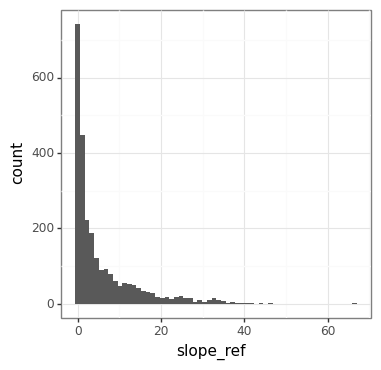

<ggplot: (1421142472409)>

In [49]:
# What are the slopes?
(
    ggplot( df_val.sample(frac=0.00001)) 
    + geom_histogram(aes(x='slope_ref'))
    + theme_bw()
    + theme(figure_size=(4,4), strip_text = element_text(size=9)) 
)

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


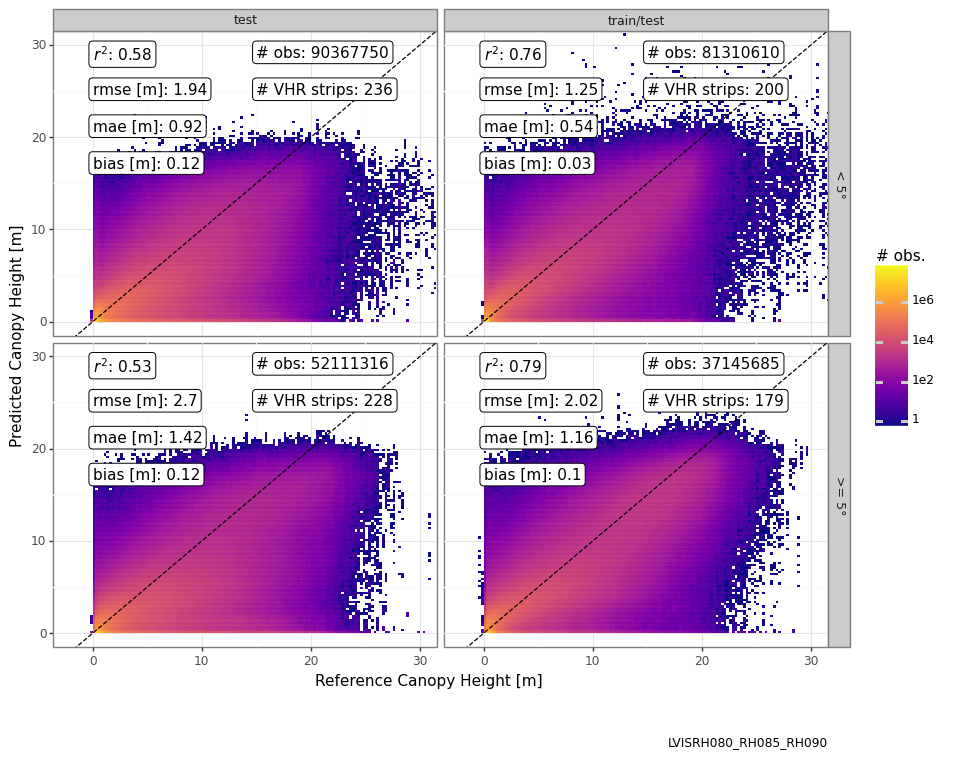


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_slope_class_model_use_class_nVHR0843_RH080.png
CPU times: user 1h 1min 16s, sys: 9min 19s, total: 1h 10min 35s
Wall time: 1h 10min 25s


slope_class model_use_class variable         n  slope  intercept  r_value  \
0        < 5°            test    RH080  90367750   0.56       0.12     0.76   
1        < 5°      train/test    RH080  81310610   0.76       0.03     0.87   
2       >= 5°            test    RH080  52111316   0.52       0.12     0.73   
3       >= 5°      train/test    RH080  37145685   0.79       0.10     0.89   

   p_value  std_err ref_var  ...  expvarscore   mae   mse  rmse  medae  \
0      0.0      0.0   value  ...         0.58  0.92  3.75  1.94   0.27   
1      0.0      0.0   value  ...         0.76  0.54  1.56  1.25   0.18   
2      0.0      0.0   value  ...         0.54  1.42  7.28  2.70   0.53   
3      0.0      0.0   value  ...         0.79  1.16  4.07  2.02   0.53   

   r2_value  r2_value_str        rmse_str        mae_str        bias_str  
0      0.58   $r^2$: 0.58  rmse [m]: 1.94  mae [m]: 0.92  bias [m]: 0.12  
1      0.76   $r^2$: 0.76  rmse [m]: 1.25  mae [m]: 0.54  bias [m]: 0.03  
2      0.53   $r^2$: 0.53   rmse [m]: 2.7  mae [m]: 1.42  bias [m]: 0.12  
3      0.79   $r^2$: 0.79  rmse [m]: 2.02  mae [m]: 1.16   bias [m]: 0.1  

[4 rows x 21 columns]

In [50]:
%%time

df_validation_smry_stats = plot_scatter_melt_3(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR_LIST=['slope_class','model_use_class'])
df_validation_smry_stats.head()

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


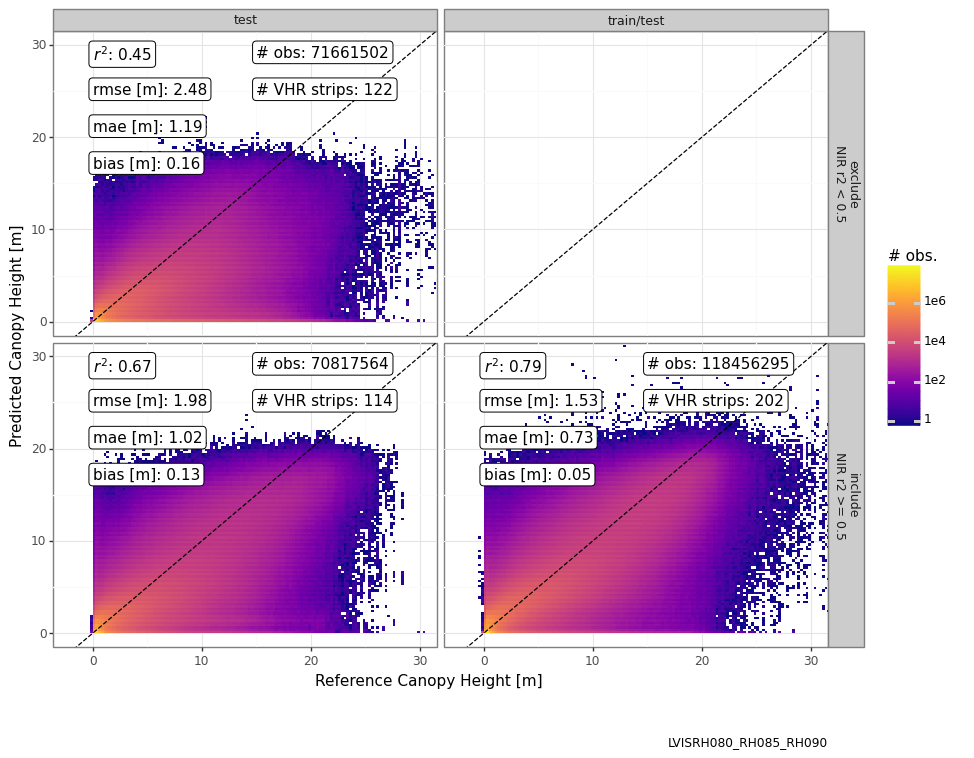


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_srlite_class_model_use_class_nVHR0438_RH080.png
CPU times: user 1h 2min 54s, sys: 9min 32s, total: 1h 12min 27s
Wall time: 1h 12min 22s


srlite_class model_use_class variable          n  slope  \
0   exclude\nNIR r2 < 0.5            test    RH080   71661502   0.41   
1  include\nNIR r2 >= 0.5            test    RH080   70817564   0.65   
2  include\nNIR r2 >= 0.5      train/test    RH080  118456295   0.78   

   intercept  r_value  p_value  std_err ref_var  ...  expvarscore   mae   mse  \
0       0.16     0.67      0.0      0.0   value  ...         0.44  1.19  6.17   
1       0.13     0.82      0.0      0.0   value  ...         0.67  1.02  3.90   
2       0.05     0.89      0.0      0.0   value  ...         0.79  0.73  2.34   

   rmse  medae  r2_value  r2_value_str        rmse_str        mae_str  \
0  2.48   0.32      0.45   $r^2$: 0.45  rmse [m]: 2.48  mae [m]: 1.19   
1  1.98   0.38      0.67   $r^2$: 0.67  rmse [m]: 1.98  mae [m]: 1.02   
2  1.53   0.27      0.79   $r^2$: 0.79  rmse [m]: 1.53  mae [m]: 0.73   

         bias_str  
0  bias [m]: 0.16  
1  bias [m]: 0.13  
2  bias [m]: 0.05  

[3 rows x 21 columns]

In [51]:
%%time

df_validation_smry_stats = plot_scatter_melt_3(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR_LIST=['srlite_class','model_use_class'])
df_validation_smry_stats.head()

## Summarize and Plot validation obs 
#### across LVIS RH metrics

Cols to drop: ['ht_m_ref_RH085', 'ht_m_ref_RH090']
['RH080']


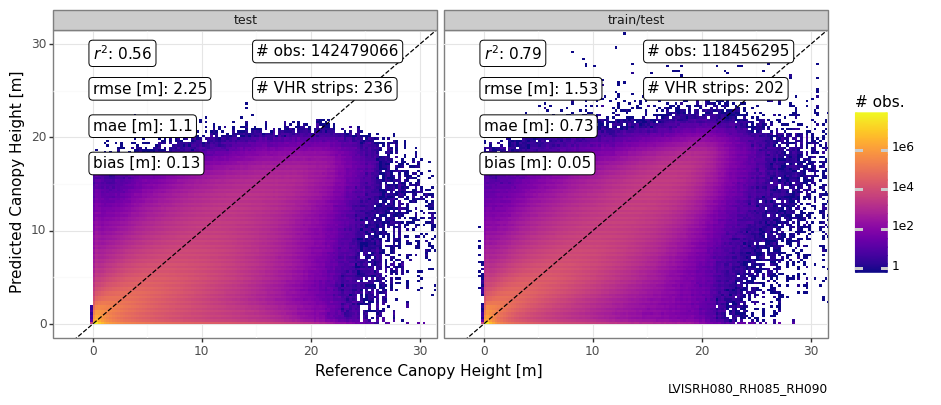


Saved /explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/plots/plot_scatter_model_use_class_nVHR0438_RH080.png
CPU times: user 30min 34s, sys: 5min 24s, total: 35min 58s
Wall time: 35min 52s


model_use_class variable          n  slope  intercept  r_value  p_value  \
0            test    RH080  142479066   0.54       0.13     0.75      0.0   
1      train/test    RH080  118456295   0.78       0.05     0.89      0.0   

   std_err ref_var  r2score  expvarscore   mae   mse  rmse  medae  r2_value  \
0      0.0   value     0.50         0.56  1.10  5.04  2.25   0.35      0.56   
1      0.0   value     0.78         0.79  0.73  2.34  1.53   0.27      0.79   

  r2_value_str        rmse_str        mae_str        bias_str  
0  $r^2$: 0.56  rmse [m]: 2.25   mae [m]: 1.1  bias [m]: 0.13  
1  $r^2$: 0.79  rmse [m]: 1.53  mae [m]: 0.73  bias [m]: 0.05

In [52]:
%%time

df_validation_smry_stats = plot_scatter_melt_2(df_val.sample(frac=1), 1, LIST_REF_METRICS[0:1], FACET_VAR='model_use_class')
df_validation_smry_stats.head()

In [47]:
df_val.head()

ht_m_src  ht_m_ref_RH080  ht_m_ref_RH085  ht_m_ref_RH090  tcc_ref  \
0       2.8        9.073636        9.602727       10.714545   5608.0   
1       2.4        9.073636        9.602727       10.714545   5608.0   
2       0.4       12.725294       13.531177       14.698236   6653.0   
3       0.6       12.725294       13.531177       14.698236   6653.0   
4       6.4        3.348182        3.768182        4.291818   4210.0   

   slope_ref  cnt_ref tcc_class  \
0   0.182577     11.0    41-60%   
1   0.182577     11.0    41-60%   
2   0.524835     17.0    61-80%   
3   0.524835     17.0    61-80%   
4   0.508962     11.0    41-60%   

                                                file        date      type  \
0  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
1  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
2  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
3  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   
4  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  2019-07-23  CHM pred   

                                      footprint_name             catid sensor  \
0  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
1  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
2  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
3  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   
4  WV03_20190723_M1BS_10400100506ED100-chm-dm-10m...  10400100506ED100   WV03   

   year  month slope_class            srlite_class model_use_class  
0  2019      7        < 5°  include\nNIR r2 >= 0.5           train  
1  2019      7        < 5°  include\nNIR r2 >= 0.5           train  
2  2019      7        < 5°  include\nNIR r2 >= 0.5           train  
3  2019      7        < 5°  include\nNIR r2 >= 0.5           train  
4  2019      7        < 5°  include\nNIR r2 >= 0.5           train

#### across LVIS RH metrics and years

In [53]:
%%time

df_validation_smry_stats_YEAR = plot_scatter_melt_2(df_val.sample(frac=1), 1, LIST_REF_METRICS, FACET_VAR='year')
df_validation_smry_stats_YEAR


KeyboardInterrupt



#### Summarize: Distribution of validation observations across LVIS RH metrics
--- replaced above---

In [55]:
# %%time
# def do_val_smry(REF_VAR):
#     return df_val.groupby(['type']).apply(validation_smry_stats, REF_VAR, 'ht_m_src').reset_index()
    
# if True:
#     with Pool(processes=3) as pool:
#         df_val_smry_list = pool.map(partial(do_val_smry), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
# else:
#     df_val_smry_list = [df_val.groupby(['type']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
    
# df_val_smry_RHmetric = pd.concat(df_val_smry_list)
# df_val_smry_RHmetric

### Plot overall
--- replaced above---

In [ ]:
%%time
if True:
    with Pool(processes=3) as pool:
        p_list = pool.map(partial(plot_scatter, df_val, 1, df_val_smry_RHmetric), ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] )
else:
    [plot_scatter(df_val, 1, df_val_smry_RHmetric, x_var) for x_var in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]

In [357]:
print(f'Validation data frame has {df_val.shape[0]/1e9:,} billion observations of 10 m pred. vs obs. canopy height estimates across Alaska')

Validation data frame has 0.260935361 billion observations of 10 m pred. vs obs. canopy height estimates across Alaska


#### Summarize: Distribution of validation observations across LVIS RH metrics  
 - year

In [243]:
%%time

df_smry_year_list = [df_val.sample(frac=1).groupby(['year']).apply(validation_smry_stats, x, 'ht_m_src').reset_index() for x in ['ht_m_ref_RH050','ht_m_ref_RH075','ht_m_ref_RH098'] ]
df_smry_year = pd.concat(df_smry_year_list).round(3)
df_smry_year.head(10)

CPU times: user 5.97 s, sys: 11.3 ms, total: 5.98 s
Wall time: 6 s


year       n  slope  intercept  r_value  p_value  std_err         ref_var  \
0  2012  140648  1.052      0.271    0.697      0.0    0.003  ht_m_ref_RH050   
1  2013  611962  0.803      0.515    0.767      0.0    0.001  ht_m_ref_RH050   
2  2014  393848  0.779      0.562    0.567      0.0    0.002  ht_m_ref_RH050   
3  2015  116056  0.118      0.036    0.019      0.0    0.018  ht_m_ref_RH050   
4  2016  858571  0.214      0.269    0.362      0.0    0.001  ht_m_ref_RH050   
5  2017   32765  3.693      0.885    0.587      0.0    0.028  ht_m_ref_RH050   
6  2019  640004  1.042      1.136    0.911      0.0    0.001  ht_m_ref_RH050   
0  2012  140648  0.614     -0.050    0.821      0.0    0.001  ht_m_ref_RH075   
1  2013  611962  0.645      0.091    0.831      0.0    0.001  ht_m_ref_RH075   
2  2014  393848  0.576      0.114    0.687      0.0    0.001  ht_m_ref_RH075   

   r2score  expvarscore    mae    mse   rmse  medae  
0   -0.964       -0.174  0.270  0.169  0.411  0.230  
1    0.435        0.511  0.629  1.206  1.098  0.203  
2   -0.586       -0.327  0.718  1.457  1.207  0.300  
3  -84.634      -36.790  0.142  0.036  0.190  0.120  
4    0.077        0.079  0.795  3.956  1.989  0.217  
5  -97.827      -32.180  0.346  0.181  0.425  0.234  
6    0.697        0.776  1.503  5.709  2.389  0.740  
0    0.627        0.669  0.148  0.131  0.361  0.101  
1    0.648        0.687  0.678  1.365  1.169  0.285  
2    0.381        0.449  0.699  1.524  1.234  0.274

### Plot stats summary results by LVIS RH

In [244]:
df_smry_year_m = pd.melt(df_smry_year, id_vars=['year', 'ref_var'] , value_vars=['r2score','expvarscore','mae','mse','rmse','medae'])
df_smry_year_m

year         ref_var variable   value
0    2012  ht_m_ref_RH050  r2score  -0.964
1    2013  ht_m_ref_RH050  r2score   0.435
2    2014  ht_m_ref_RH050  r2score  -0.586
3    2015  ht_m_ref_RH050  r2score -84.634
4    2016  ht_m_ref_RH050  r2score   0.077
..    ...             ...      ...     ...
121  2014  ht_m_ref_RH098    medae   1.955
122  2015  ht_m_ref_RH098    medae   0.847
123  2016  ht_m_ref_RH098    medae   0.855
124  2017  ht_m_ref_RH098    medae   1.250
125  2019  ht_m_ref_RH098    medae   1.485

[126 rows x 4 columns]

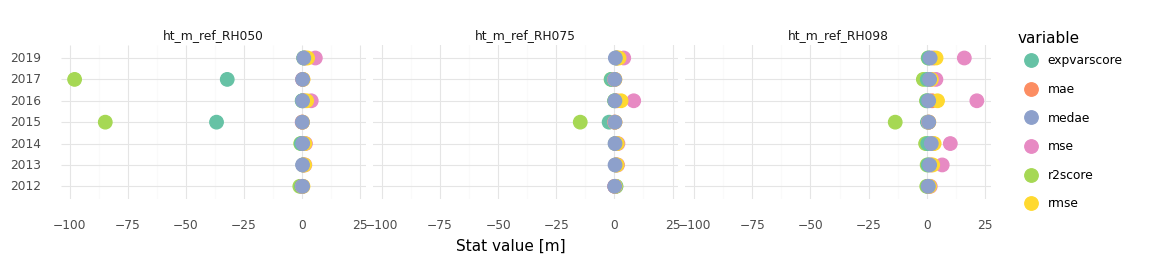

<ggplot: (1437480987405)>

In [249]:
( 
    ggplot(df_smry_year_m, aes(x='value', y='factor(year)', color='variable'))
        + geom_point(size=5)
    + scale_color_brewer(type='qual', palette=7)
    + labs(y = None, x = 'Stat value [m]')
    + facet_grid('~ ref_var')
    + theme_minimal()
    + theme(figure_size = (12,2))

)


# Use vhr metadata to examine predictions = 0  
 - do these 0 vals come from only a few strips?  
 - is there a link to sub-optimal SSG?